# Misconfiguration detection framework
The misconfiguration detection framework adopted in this project is inspired by the research paper ['Synthesizing Configuration File Specifications with Association Rule Learning'](https://www.cs.yale.edu/homes/zhai-ennan/configv-oopsla17.pdf#cite.santolucitoCAV). Association rule learning is a method to discover frequently occurring patterns or associations between variables in a dataset. In association rule learning, support and confidence are two metrics widely used to filter the proposed rules. Support is the percentage of times that the keywords in the proposed rule have been seen in the training configuration files. Confidence is the percentage of times the proposed rule has held true over the training configuration files.

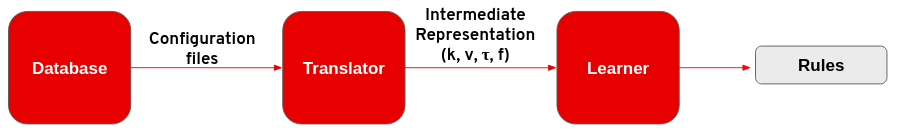

In [1]:
from IPython.display import Image
Image('images/framework.png')

Misconfiguration detection framework has two important modules: translator and learner. <br>
- **Translator**: Translator works as a parser, translator converts raw configuration files into an intermediate representation which generally has a format of key, value, data type, frequency (k, v, τ, f) <br>
- **Learner**:: Learner discovers frequently occurring patterns or associations between keywords in configuration files to derive rules. <br>

# In this notebook, our objective is to find spelling errors.

A common and subtle error is for user-written configuration files to assign values to keys that program never reads. This issue mainly happened because of misspelling in key names. Misspelling in a key name might not result in any immediate overt failure. Instead, it will result in a default value assignment, resulting in impaired performance and reliability that may be challenging to track down. 


## Spelling error detection framework
Following is the example of a spelling error detection framework

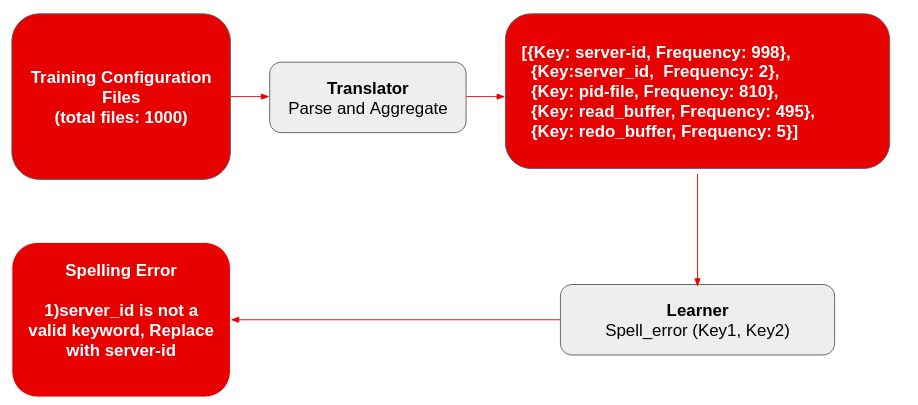

In [2]:
Image('images/spell_error_framework.png')

Steps for spelling error detection <br>
1) Translator finds the frequency of each keyword across the training set. <br>
2) Learner proposes errors by mapping lower frequency keywords to a similar higher frequency keyword. We calculated the similarity between keywords using Levenshtein distance. Finally, learner filters the proposed errors using support and confidence. <br>

Levenshtein distance:  Minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word into another word. <br>
For example: debug and debig have a Levenshtein distance of 1

In this notebook, we are finding spelling errors in mysql.conf files. Dataset used in this notebook is publically available on the [Github](https://github.com/tianyin/configuration_datasets). You can download the data by running the script [data_downloader.py](https://github.com/aicoe-aiops/configuration-files-analysis/tree/master/notebooks/data_downloader.py) in the same directory where this notebook exists.

## Spelling errors in mysql.cnf files

In [3]:
import os
import json
import pandas as pd
import numpy as np
from itertools import combinations
import nltk
import re
from collections import defaultdict
import configparser

In [4]:
# Below function parses all the configuration files based on ini type configuration files.        
        
def get_typos(key_freq, confidence_t=0.9, typo_limit=2):
    """This function finds typos based on keyword frequencies.

    We find similar words and filter the results based on the confidence threshold.

    Parameters
    ----------
    key_freq : dictionary 
            Frequency of keyword in configuration files.
    confidence_t : float, default 0.9
            confidence threshold for spell check
    typo_limit : int, default 2
            The number of typos allowed. We calculate typos using edit distance
            For every ten characrters, we increase this argument by 1

    Returns
    ----------
    spell_errors: dictionary
            key in the dictionary is a misspelled keyword, and value is the correct version of a keyword
    """
    spell_errors = {}
    for i, j in combinations(key_freq.keys(), r=2):
        # Calculated similarity between keyword using Levenshtein distance.
        if nltk.edit_distance(i, j) >= min(len(i), len(j))//10+typo_limit:
            continue
        if key_freq[i] >= key_freq[j]:
            if key_freq[i]/(key_freq[i] + key_freq[j]) > confidence_t:
                spell_errors[j] = i
        else:
            if key_freq[j]/(key_freq[i] + key_freq[j]) > confidence_t:           
                spell_errors[i] = j
    return spell_errors

# Create_KeyValue_df function takes input as a folder path and creates a list of dictionaries as output 
def create_keyvalue_df(data_dir, fixed_typos=True):
    """This function creates a list of dictionaries as output for a set of configuration files.

    We parse and convert each configuration file into a dictionary format. 
    and append all this dictionary into a list

    Parameters
    ----------
    folder_path : string
            folder path of the configuration files.
    fixed_typos : bool, default True
            If True, fixed typos in configuration files.

    Returns
    ----------
    dict_list: list of dictionaries
            list where each element is a dictionary of a configuration file.
    """
    dict_list = []
    parse_errors = 0
    errorconfigs_filename = []
    
    for filename in os.listdir(data_dir):
        try:
            ## Adding dummy section to avoid no header error
            with open(os.path.join(data_dir, filename), 'r') as f:
                config_string = '[dummy_section]\n' + f.read()
            config = configparser.ConfigParser(allow_no_value=True, strict=False, inline_comment_prefixes= '#')
            cfgs = {}
            config.read_string(config_string)
            for sect in config.sections():
                cfgs.update(dict(config.items(sect)))
            dict_list.append(cfgs)
        except:
            errorconfigs_filename.append(filename)
            parse_errors += 1
    
    if fixed_typos:
        ## Fixed typos
        ## Create dataframe
        config_df = pd.DataFrame(dict_list)
        ## Find count of each key
        key_dict = config_df.count().to_dict()
        ## get typos based on frequncy of keys
        key_changes = get_typos(key_dict)
        ## Fix typos
        for dict_i in dict_list:
            for key in dict_i.copy():
                if key in key_changes:
                    dict_i[key_changes[key]] = dict_i.pop(key)

    
    return dict_list

#### The following cell work as a translator; translator parses configuration files and finds the frequency of each keyword across the training set.

In [5]:
## translator
data_dir = '../data/raw/mysql'
dict_list = create_keyvalue_df(data_dir,fixed_typos=False)
config_df = pd.DataFrame(dict_list)
config_df = config_df.dropna(axis=1, how='all')
key_dict = config_df.count().to_dict()

#### The following cell work as a learner; Learner proposes errors by mapping lower frequency keywords to a similar higher frequency keyword. filters rules using support and confidence 
We calculated the similarity between keywords using Levenshtein distance.

In [6]:
### Following function find similar words and filter the results based on confidence thersold
def spell_error(key_freq, total_files, typo_limit=2, confidence_t=0.90, support_t=0.1):
    """This function proposes spelling errors by mapping lower frequency keywords to a similar higher frequency keyword. 

    We filter rules using support and confidence. Also, we calculate the similarity between keywords using Levenshtein distance.

    Parameters
    ----------
    key_freq : dictionary 
            Freqency of keyword in configuration files.
    typo_limit : int, default 2
            The number of typos allowed. We calculate typos using edit distance
            For every ten characrters, we increase this argument by 1
    confidence_t : float, default 0.9
            confidence thersold for spelling errors
    support_t : float, default 0.1
            confidence thersold for spelling errors

    Returns
    ----------
    spell_errors: dictionary
            keys in the dictionary are misspelled keywords, and values are the correct version of the keywords.
    """
    spell_errors = {}
    for i, j in combinations(key_freq.keys(), r=2):
            # Calculated similarity between keyword using Levenshtein distance.
            if nltk.edit_distance(i, j) >= min(len(i),len(j))//10+typo_limit:
                continue
            # Filter using support, we are assuming if a keyword is misspelled, Correctly spell keyword will not be present in the configuration file and vice-versa
            if ((key_freq[i] + key_freq[j])/(total_files)) > support_t:
                if key_freq[i] >= key_freq[j]:
                    # Considered it as a rule only if confidence is more than confidence_t(confidence thersold)
                    if key_freq[i]/(key_freq[i] + key_freq[j])> confidence_t:
                        spell_errors[j] = i
                else:
                    # Considered it as a rule only if confidence is more than confidence_t(confidence thersold)
                    if key_freq[j]/(key_freq[i] + key_freq[j])> confidence_t:                       
                        spell_errors[i] = j
    return spell_errors

## Learner
spell_errors = spell_error(key_dict, len(dict_list), support_t = 0.01)
spell_errors

{'!includedir /etc/mysql/conf.d': '!includedir /etc/mysql/conf.d/',
 'includedir /etc/mysql/conf.d/': '!includedir /etc/mysql/conf.d/',
 'bind_address': 'bind-address',
 'binlog_do_db': 'binlog-do-db',
 'default_character_set': 'default-character-set',
 'err_log': 'err-log',
 'expire-logs-days': 'expire_logs_days',
 'innodb-buffer-pool-size': 'innodb_buffer_pool_size',
 'innodb-file-per-table': 'innodb_file_per_table',
 'innodb-flush-method': 'innodb_flush_method',
 'innodb-log-buffer-size': 'innodb_log_buffer_size',
 'innodb-log-file-size': 'innodb_log_file_size',
 'innodb-open-files': 'innodb_open_files',
 'innodb-thread-concurrency': 'innodb_thread_concurrency',
 'join-buffer-size': 'join_buffer_size',
 'key-buffer-size': 'key_buffer_size',
 'log_slow_querie': 'log_slow_queries',
 'long-query-time': 'long_query_time',
 'max-allowed-packet': 'max_allowed_packet',
 'max-connections': 'max_connections',
 'myisam-sort-buffer-size': 'myisam_sort_buffer_size',
 'old-passwords': 'old_passw

Inferences of some of the above-detected errors in mysql.conf file: <br>
- Our first error is the keyword 'bind_address' is misspelled. It should be replaced by 'bind-address' <br>
- Our second error is the keyword 'binlog_do_db' is misspelled. It should be replaced by 'binlog-do-db' <br>
and so on.


### Percentage of spelling errors in mysql.cnf files
In the following cell, we calculated the spelling error percentage in mysql.cnf files. We mapped lower frequency keywords to similar higher frequency keywords. If such keywords exist, we considered them as errors.

In [7]:
error = 0
for dict_i in dict_list:
    for key in dict_i:
        if key in spell_errors:
            error += 1
            break
print('Percentage of spelling errors in mysql.cnf files are', round(100*error/len(dict_list), 2))

Percentage of spelling errors in mysql.cnf files are 13.18


### Spelling error detection in a particular file mysql.cnf
In the following cell, we found spelling errors in a mysql.cnf file in our dataset. <br>
We parsed the configuration file and checked if there are lower-frequency keywords similar to a higher-frequency keyword. If such keywords exist, we throw misspell errors. <br>

One of the most misconfigured MySQL performance features is MySQL 'query_cache_size' [refrence](https://haydenjames.io/mysql-query-cache-size-performance/). 'query_cache_size' system variable is used for query caching, and it can significantly improve the performance of the MySQL systems. A user assigned 20M memory to 'query_cache_size' to improve the performance but misspelled key as 'query-cache-size' resulting in a default 1M memory assignment causing poor performance. 

In [8]:
def mis_spell_detection(key_dict, input_file, confidence_t=0.9, typo_limit=2):
    """This function finds spelling error in a particular configuration file. 

    We parsed the configuration file and checked if there are lower-frequency keywords similar to a higher-frequency keyword.
    If such keywords exist, we throw a misspelling error message.

    Parameters
    ----------
    key_freq : dictionary 
            Frequency of keywords in configuration files.
    input_file : file_path, string
            Path of the configuration file for which we want to find data type error.
    confidence_t : float, default 0.9
            confidence threshold for spelling errors
    typo_limit : int, default 2
        The number of typos allowed. We calculate typos using edit distance
        For every ten characrters, we increase this argument by 1

    Returns
    ----------
    error_message: string
            string with error message corresponding to spelling error.
    """
    key_dict = defaultdict(int,key_dict)
    #Parsed the file
    with open(input_file) as f:
        config_string = '[dummy_section]\n' + f.read()
    config = configparser.ConfigParser(allow_no_value=True, strict=False, inline_comment_prefixes= '#')
    cfgs = {}
    config.read_string(config_string)
    for sect in config.sections():
        cfgs.update(dict(config.items(sect)))
        
    # Increamented frequency dictionary based on the current keys
    for q in cfgs:
        key_dict[q] += 1
    # Calculated all the misspell errors
    for p in cfgs:
        for q in key_dict:
            if nltk.edit_distance(p, q) >= min(len(p),len(q))//10+typo_limit:
                continue
            # Considered it as a error if confidence is more than confidence_t(confidence thersold)
            if key_dict[q]/(key_dict[p] + key_dict[q])> confidence_t:
                print('Spell_Error: Key \''+ p+'\' should be replaced by \''+ q +'\'')
                

mis_spell_detection(key_dict, '../data/raw/mysql/015c69fcac9642fd6ccedb035445eda2.cnf')

Spell_Error: Key 'query-cache-size' should be replaced by 'query_cache_size'


# Conclusion
In this notebook, we demonstrated a framework for detecting spelling errors in configuration files by mapping lower frequency keywords to a similar higher frequency keyword. Spelling errors may cause default value assignment in configuration files, resulting in impaired performance and reliability that may be challenging to track down. We can automate the spelling error detection task using data-driven methods for all types of key-values based configuration files. Our implemented framework also suggests the correct versions of the misspelled keywords. For example, we detected misconfiguration in mysql.conf files. The analysis can be easily replicated for other configuration files.